# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [1]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy

plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [3]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [4]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [6]:
# Loading the dataset
# eg.
# dirpath = './dataset/IMFDB/'
X,y = load_data("./dataset/Yale_face_database")
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
#X = X.reshape((N,H*W*C))
print(X.shape)

Dataset shape: (165, 32, 32, 3)
(165, 32, 32, 3)


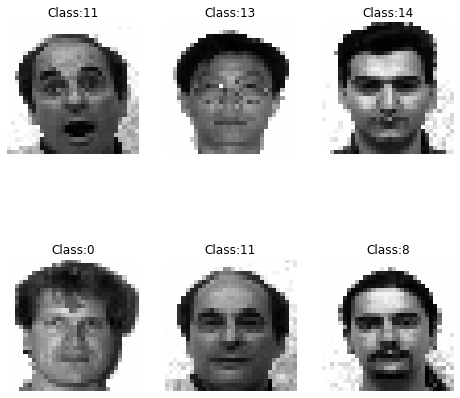

In [7]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [8]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [9]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return X_k

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [10]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k


### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [11]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [12]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [13]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features
# print(X.shape)
# feat=get_vgg_features("./Assign_dataset/dataset/Yale_face_database")
# print(feat.shape)

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [14]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features
# print(X.shape)
# feat=get_resnet_features("./Assign_dataset/dataset/Yale_face_database")
# print(feat.shape)

# Questions

1(a). What are eigen faces? 

___________________________

Your answers here (double click to edit)


In [15]:
Eigenfaces is the name given to a set of eigenvectors when they are used in the computer vision problem of 
human face recognition.
The eigenfaces themselves form a basis set of all images used to construct the covariance matrix. 
This produces dimension reduction by allowing the smaller set of basis images to represent the original training 
images. Classification can be achieved by comparing how faces are represented by the basis set.

SyntaxError: invalid syntax (<ipython-input-15-3e5355e828cd>, line 1)

1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

In [16]:
# Compute your features
# eg.
# X_3D = get_kernel_lda(X,y,3)
from numpy import linalg as LA
X,y = load_data("./dataset/Yale_face_database")
y1=deepcopy(y)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
covar=np.cov(X.T)
eig_val1,eig_vec1=LA.eig(covar)
eig_val1=eig_val1.real
eig_x1=np.arange(1,eig_val1.shape[0]+1)
sum1=0
total=np.sum(eig_val1)
for j in range(0,3072):
    sum1=sum1+eig_val1[j]
    if (sum1/total)*100>96:
        max1=j
        break
print("The number of eigen vectors required for Yale_face_database are %d"%(max1))
pca = PCA(n_components=max1)
X1_3D=pca.fit_transform(X)

X,y = load_data("./dataset/IMFDB")
y2=deepcopy(y)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
covar=np.cov(X.T)
eig_val2,eig_vec2=LA.eig(covar)
eig_val2=eig_val2.real
eig_x2=np.arange(1,eig_val2.shape[0]+1)
sum2=0
total=np.sum(eig_val2)
for j in range(0,3072):
    sum2=sum2+eig_val2[j]
    if (sum2/total)*100>96:
        max1=j
        break
print("The number of eigen vectors required for IMFDB are %d"%(max1))
pca = PCA(n_components=max1)
X2_3D=pca.fit_transform(X)

X,y = load_data("./dataset/IIIT-CFW")
y3=deepcopy(y)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
covar=np.cov(X.T)
eig_val3,eig_vec3=LA.eig(covar)
eig_val3=eig_val3.real
eig_x3=np.arange(1,eig_val3.shape[0]+1)
sum1=0
total=np.sum(eig_val3)
for j in range(0,3072):
    sum1=sum1+eig_val3[j]
    if (sum1/total)*100>96:
        max1=j
        break
print("The number of eigen vectors required for IIIT-CFW are %d"%(max1))
pca = PCA(n_components=max1)
X3_3D=pca.fit_transform(X)

Dataset shape: (165, 32, 32, 3)
The number of eigen vectors required for Yale_face_database are 69
Dataset shape: (400, 32, 32, 3)
The number of eigen vectors required for IMFDB are 142
Dataset shape: (672, 32, 32, 3)
The number of eigen vectors required for IIIT-CFW are 338


Yale_face_database


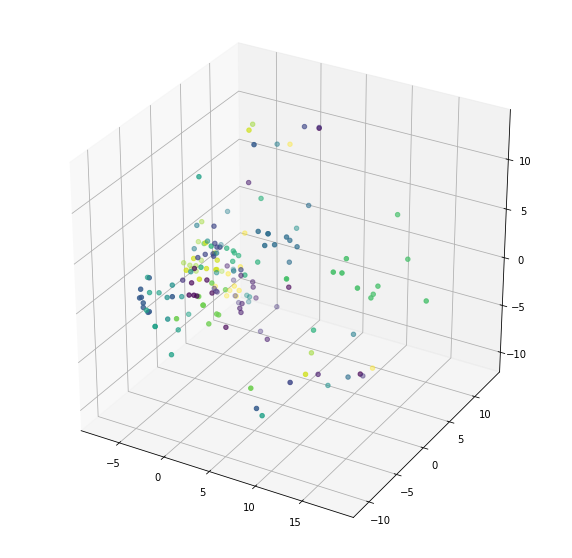

IMFDB


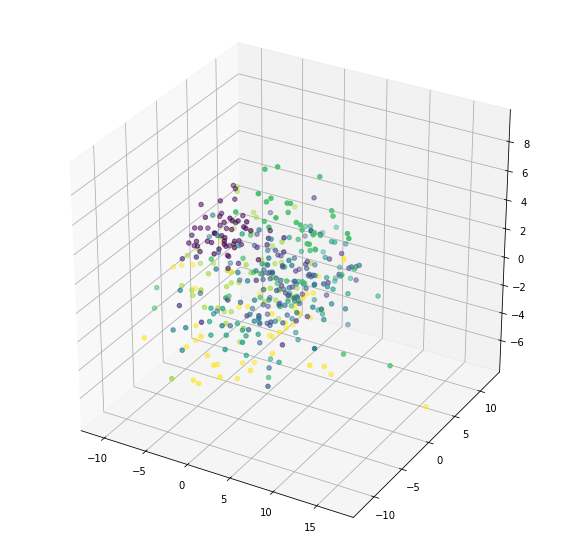

IIIT-CFW


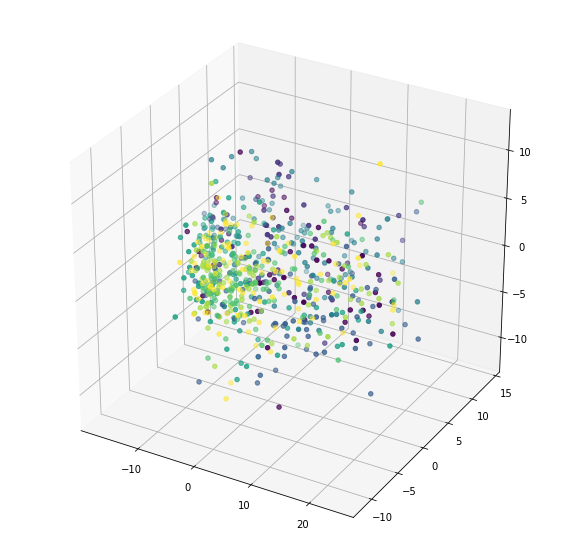

In [17]:
# Create a scatter plot  
# eg.
# fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c=y)
print("Yale_face_database")
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1_3D[:,0],X1_3D[:,1],X1_3D[:,2],c=y1)
plt.show()
print("IMFDB")
fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.scatter(X2_3D[:,0],X2_3D[:,1],X2_3D[:,2],c=y2)
plt.show()
print("IIIT-CFW")
fig2 = plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(X3_3D[:,0],X3_3D[:,1],X3_3D[:,2],c=y3)
plt.show()

Yale_face_database


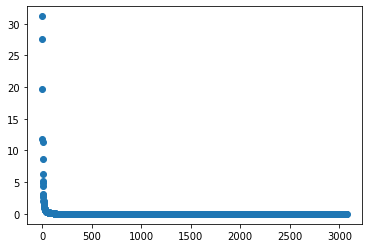

IMFDB


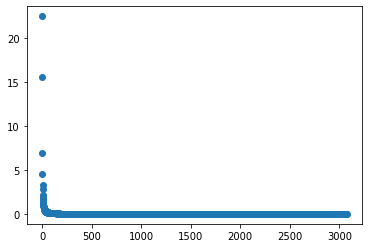

IIIT-CFW


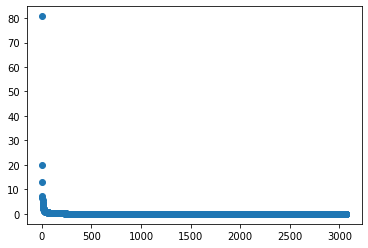

In [18]:
# Plot the eigen value spectrum 
print("Yale_face_database")
plt.scatter(eig_x1,eig_val1)
plt.show()
print("IMFDB")
plt.scatter(eig_x2,eig_val2)
plt.show()
print("IIIT-CFW")
plt.scatter(eig_x3,eig_val3)
plt.show()

1(c). Reconstruct  the  image  back for each case


In [19]:
def reconstruct_images(X_arr,reduc):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params:
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    reconstruct_X=reduc.inverse_transform(X_arr)
    return reconstruct_X

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dataset shape: (165, 32, 32, 3)
The reconstruction error is:-
0.0490803608487057
----------Dataset: Yale_face_database -------
Reconstructed and original


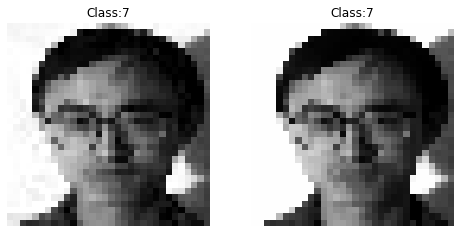

Dataset shape: (400, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The reconstruction error is:-
0.03480863680597103
----------Dataset: IMFDB -------
Reconstructed and original


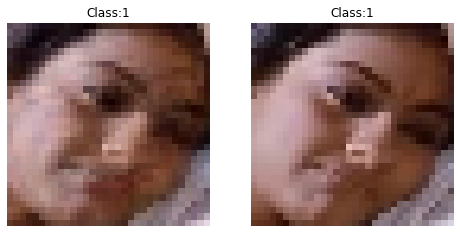

Dataset shape: (672, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The reconstruction error is:-
0.06123580723238514
----------Dataset: IIIT-CFW -------
Reconstructed and original


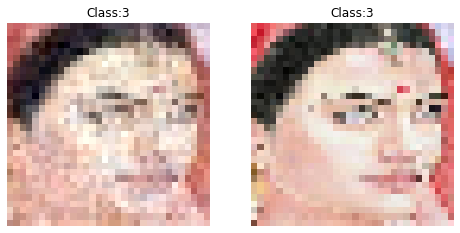

In [20]:
# Display results 
# X_reconstruced = reconstruct_images()

# Display random images
# ind = np.random.randint(0,y.shape[0],6)
# disply_images(X_reconstruced_3D[ind,...],y[ind],row=2,col=3)

# Show the reconstruction error
X,y = load_data("./dataset/Yale_face_database")
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
pca = PCA(n_components=69)
X_k = pca.fit_transform(X)
X_reconstructed = reconstruct_images(X_k,pca)
print("The reconstruction error is:-")
print(np.sqrt(np.mean((X - X_reconstructed)**2)))
rec_pca_test=np.reshape(X_reconstructed,(165,H,W,C))
ind1=np.random.randint(0,y.shape[0],1)
X_test = X.reshape([165,H,W,C])
X_disp = np.concatenate([rec_pca_test[ind1],X_test[ind1]])
y_disp = np.concatenate([y[ind1],y[ind1]])
print("----------Dataset:",'Yale_face_database',"-------")
print("Reconstructed and original")
disply_images(X_disp,y_disp,row=1,col=2)


X,y = load_data("./dataset/IMFDB")
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
pca = PCA(n_components=142)
X_k = pca.fit_transform(X)
X_reconstructed = reconstruct_images(X_k,pca)
print("The reconstruction error is:-")
print(np.sqrt(np.mean((X - X_reconstructed)**2)))
rec_pca_test=np.reshape(X_reconstructed,(400,H,W,C))
ind1=np.random.randint(0,y.shape[0],1)
X_test = X.reshape([400,H,W,C])
X_disp = np.concatenate([rec_pca_test[ind1],X_test[ind1]])
y_disp = np.concatenate([y[ind1],y[ind1]])
print("----------Dataset:",'IMFDB',"-------")
print("Reconstructed and original")
disply_images(X_disp,y_disp,row=1,col=2)

X,y = load_data("./dataset/IIIT-CFW")
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
pca = PCA(n_components=338)
X_k = pca.fit_transform(X)
X_reconstructed = reconstruct_images(X_k,pca)
print("The reconstruction error is:-")
print(np.sqrt(np.mean((X - X_reconstructed)**2)))
rec_pca_test=np.reshape(X_reconstructed,(672,H,W,C))
ind1=np.random.randint(0,y.shape[0],1)
X_test = X.reshape([672,H,W,C])
X_disp = np.concatenate([rec_pca_test[ind1],X_test[ind1]])
y_disp = np.concatenate([y[ind1],y[ind1]])
print("----------Dataset:",'IIIT-CFW',"-------")
print("Reconstructed and original")
disply_images(X_disp,y_disp,row=1,col=2)

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

Dataset shape: (400, 32, 32, 3)
IMFDB
The person who requires less eigen vectors is KatrinaKaif
The person who requires more eigen vectors is MadhuriDixit
Dataset shape: (400, 32, 32, 3)
The reconstruction error is:-
0.06881512954665818
----------Dataset: IMFDB -------
Reconstructed and original for madhuri Dixit


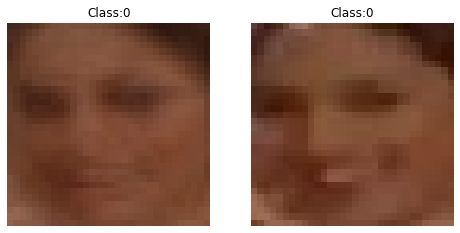

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The reconstruction error is:-
0.07532888778055047
----------Dataset: IMFDB -------
Reconstructed and original for Katrina Kaif


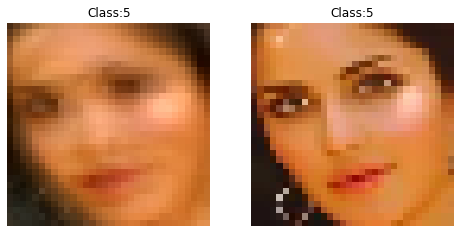

In [22]:
# code goes here
temp_dict = {0:'MadhuriDixit',
     1:'Kajol',
     2:'SharukhKhan',
     3:'ShilpaShetty',
     4:'AmitabhBachan',
     5:'KatrinaKaif',
     6:'AkshayKumar',
     7:'Amir'}
X,y = load_data("./dataset/IMFDB")
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
# eig_vec11=eig_vec1[:,:X1_3D.shape[1]]
# eig_vec11=eig_vec11.T
# X_reconstructed = reconstruct_images(X1_3D,eig_vec11)
print("IMFDB")
data_classes=[[] for i in range(0,8)]
for j in range(0,X.shape[0]):
    data_classes[y[j]].append(X[j])
data_classes=np.array(data_classes)
max_eig=[]
max1=0
for i in range(0,8):
    max1=0
    sum1=0
    temparr=data_classes[i]
    cov_mar=np.cov(temparr.T)
    eigval,eigvec=LA.eig(cov_mar)
    total=np.sum(eigval)
    for j in range(0,3072):
        sum1=sum1+eigval[j]
        if (sum1/total)*100>96:
            max1=j
            break
    max_eig.append(max1)
max_eig=np.array(max_eig)
max1=np.argmax(max_eig)
min1=np.argmin(max_eig)
print("The person who requires less eigen vectors is %s" %(temp_dict[min1]))
print("The person who requires more eigen vectors is %s" %(temp_dict[max1]))
X,y = load_data("./dataset/IMFDB")
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
pca = PCA(n_components=max_eig[max1])
X_k = pca.fit_transform(X)
X_reconstructed = reconstruct_images(X_k,pca)
print("The reconstruction error is:-")
print(np.sqrt(np.mean((X - X_reconstructed)**2)))
rec_pca_test=np.reshape(X_reconstructed,(400,H,W,C))
ind1=np.random.randint(250,300,1)
X_test = X.reshape([400,H,W,C])
X_disp = np.concatenate([rec_pca_test[ind1],X_test[ind1]])
y_disp = np.concatenate([y[ind1],y[ind1]])
print("----------Dataset:",'IMFDB',"-------")
print("Reconstructed and original for madhuri Dixit")
disply_images(X_disp,y_disp,row=1,col=2)

pca = PCA(n_components=max_eig[min1])
X_k = pca.fit_transform(X)
X_reconstructed = reconstruct_images(X_k,pca)
print("The reconstruction error is:-")
print(np.sqrt(np.mean((X - X_reconstructed)**2)))
rec_pca_test=np.reshape(X_reconstructed,(400,H,W,C))
ind1=np.random.randint(200,250,1)
X_test = X.reshape([400,H,W,C])
X_disp = np.concatenate([rec_pca_test[ind1],X_test[ind1]])
y_disp = np.concatenate([y[ind1],y[ind1]])
print("----------Dataset:",'IMFDB',"-------")
print("Reconstructed and original for Katrina Kaif")
disply_images(X_disp,y_disp,row=1,col=2)

2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [23]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix as confuse_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
class Classifier():
    def __init__(self,X_train,y_train,X_test,y_test):
        #super.__init__()
        self.X_train=X_train
        self.y_train=y_train
        self.X_test=X_test
        self.y_test=y_test
    def classify(self,classif):
        """
            Given an input X classify it into appropriate class.
        """
        pred=classif.predict(self.X_test)
        return pred
        
    def confusion_matrix(self,pred):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        cm = confuse_matrix(self.y_test,pred)
        return cm
    
    def train(self,params):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label

            @return Nothing
        """
        if params=='MLP':
            classy=MLPClassifier(hidden_layer_sizes=(200,50),max_iter=200)
            clf=classy.fit(self.X_train,self.y_train)
            final=self.validate(clf)
            return final
        elif params=='Logistic_Regression':
            classy=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
            classy=LogisticRegression(random_state=0)
            clf=classy.fit(self.X_train,self.y_train)
            final=self.validate(clf)
            return final
        elif params=='SVM':
            classy=SVC(C=3,kernel='rbf',random_state=0,gamma=0.1)
            clf=classy.fit(self.X_train,self.y_train)
            final=self.validate(clf)
            return final
        elif params=='Decision_trees':
            classy=tree.DecisionTreeClassifier()
            clf=classy.fit(self.X_train,self.y_train)
            final=self.validate(clf)
            return final
    def validate(self,clf_param):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        result=[]
        predict=self.classify(clf_param)
        cm=self.confusion_matrix(predict)
        accuracy=cm.trace()/(self.X_test).shape[0]
        result.append(accuracy*100)
        result.append(cm)
        metrics_list=[]
        metrics=precision_recall_fscore_support(self.y_test, predict,average='macro')
        metrics_list.append(metrics[0]*100)
        metrics_list.append(metrics[1]*100)
        metrics_list.append(metrics[2]*100)
        result.extend(metrics_list)
        result=np.array(result[0:5])
        return result

In [24]:
# Create a train and validation split to train your classifier
temp_str=["Yale_face_database","IMFDB","IIIT-CFW"]
temp3_str=deepcopy(temp_str)
classes=[15,8,8]
for d in range(0,3):
    temp_str[d]="./dataset/"+temp_str[d]
best=[]
best_confs=[]
def split_data(X,y):
    j=0
    temp_arr=np.arange(X.shape[0])
    train_data=np.array([])
    train_indices=[]
    test_indices=[]
    test_data=np.array([])
    train_labels=[]
    test_labels=[]
    while j<X.shape[0]:
            y=y.tolist()
            num_data=y.count(y[j])
            split=num_data-3
            y=np.array(y)
            train_indices.extend(temp_arr[j:j+split])
            test_indices.extend(temp_arr[j+split:j+num_data])
            train_labels=train_labels+[y[j]]*split
            test_labels=test_labels+[y[j]]*(num_data-split)
            j=j+num_data
    train_data=X[train_indices]
    test_data=X[test_indices]
    train_labels=np.array(train_labels)
    test_labels=np.array(test_labels)
    return train_data,test_data,train_labels,test_labels

for k in range(0,3):
        accu=[]
        confs=[]
        X,y = load_data(temp_str[k])
        N,H,W = X.shape[0:3]
        C = 1 if opt['is_grayscale'] else X.shape[3]
        X = X.reshape((N,H*W*C))
        cm=[]
        train_data,test_data,train_labels,test_labels=split_data(X,y)
        mat_metric=[]
        
        classif=Classifier(train_data,train_labels,test_data,test_labels)
        MLP_classif=classif.train('MLP')
        mat_metric.append(MLP_classif)
        Logis_classif=classif.train('Logistic_Regression')
        mat_metric.append(Logis_classif)
        SVM_classif=classif.train('SVM')
        mat_metric.append(SVM_classif)
        Decision_classif=classif.train('Decision_trees')
        mat_metric.append(Decision_classif)
        mat_metric=np.array(mat_metric)
        best.append(np.argmax(mat_metric[:,0]))
        best_confs.append(mat_metric[best[k]][1])
        dodo=np.argmax(mat_metric[:,0])
        print(temp3_str[k])
        print("The classification accuracy for the best classifier is %f"%(mat_metric[dodo][0]))
best=np.array(best)
best_confs=np.array(best_confs)

Dataset shape: (165, 32, 32, 3)
Yale_face_database
The classification accuracy for the best classifier is 100.000000
Dataset shape: (400, 32, 32, 3)
IMFDB
The classification accuracy for the best classifier is 75.000000
Dataset shape: (672, 32, 32, 3)
IIIT-CFW
The classification accuracy for the best classifier is 50.000000


In [25]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score
import pandas as pd
columns=['Method','Reduced','Classification_error','Accuracy','F1-Score']
index=['1','2','3','4']
temp_str=["Yale_face_database","IMFDB","IIIT-CFW"]
temp_str1=deepcopy(temp_str)
for d in range(0,3):
    temp_str[d]="./dataset/"+temp_str[d]
data=[]

func_arr=[get_pca,get_kernel_pca,get_lda,get_kernel_lda,get_vgg_features,get_resnet_features]
func_str=['get_pca','get_kernel_pca','get_lda','get_kernel_lda','get_vgg_features','get_resnet_features']
classif_arr=['MLP','Logistic_Regression','SVM','Decision_trees']
conf_mat=[]
for i in range(0,3):
    X,y = load_data(temp_str[i])
    N,H,W = X.shape[0:3]
    C = 1 if opt['is_grayscale'] else X.shape[3]
    X = X.reshape((N,H*W*C))
    for j in range(0,len(func_arr)):
        if j==0:
                feat=func_arr[j](X,100)
        if j==2:
            feat=func_arr[j](X,y,100)
        if j==4 or j==5:
            feat=func_arr[j](temp_str[i])
        if j==1:
            feat=func_arr[j](X,100,kernel='rbf', degree=3)
        if j==3:
            feat=func_arr[j](X,y,100,kernel='rbf',degree=3)
        for k in range(0,len(classif_arr)):
            train_data,test_data,train_labels,test_labels=split_data(feat,y)
            classif=Classifier(train_data,train_labels,test_data,test_labels)
            temp_classif=classif.train(classif_arr[k])
            conf_mat.append(temp_classif[1])
            s3 = "{}+{}".format(func_str[j],classif_arr[k])
            data.append([s3,feat.shape[1],100-temp_classif[0],temp_classif[0],temp_classif[4]])
data=np.array(data)
dd=0
while dd<data.shape[0]:
    df=pd.DataFrame(data[dd:dd+4],columns=columns, index=index)
    if dd>=0 and dd<24:
        print("Yale_face_database")
    elif dd>=24 and dd<48:
        print("IMFDB")
    else:
        print("IIIT-CFW")
    display(df)
    dd=dd+4
# Print the table. (You can use Pandas)

Dataset shape: (165, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Yale_face_database


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_pca+MLP,100,8.888888888888886,91.11111111111111,91.15873015873017
2,get_pca+Logistic_Regression,100,0.0,100.0,100.0
3,get_pca+SVM,100,46.666666666666664,53.333333333333336,54.8148148148148
4,get_pca+Decision_trees,100,28.888888888888886,71.11111111111111,67.96825396825396


Yale_face_database


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_kernel_pca+MLP,100,15.555555555555557,84.44444444444444,83.58730158730158
2,get_kernel_pca+Logistic_Regression,100,13.333333333333329,86.66666666666667,85.82539682539684
3,get_kernel_pca+SVM,100,11.111111111111114,88.88888888888889,88.38095238095238
4,get_kernel_pca+Decision_trees,100,42.22222222222223,57.77777777777777,56.61904761904761


Yale_face_database


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_lda+MLP,14,0.0,100.0,100.0
2,get_lda+Logistic_Regression,14,0.0,100.0,100.0
3,get_lda+SVM,14,11.111111111111114,88.88888888888889,89.63636363636364
4,get_lda+Decision_trees,14,8.888888888888886,91.11111111111111,91.0952380952381


Yale_face_database


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_kernel_lda+MLP,14,0.0,100.0,100.0
2,get_kernel_lda+Logistic_Regression,14,0.0,100.0,100.0
3,get_kernel_lda+SVM,14,11.111111111111114,88.88888888888889,89.63636363636364
4,get_kernel_lda+Decision_trees,14,8.888888888888886,91.11111111111111,90.66666666666666


Yale_face_database


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_vgg_features+MLP,4096,35.55555555555556,64.44444444444444,63.597883597883595
2,get_vgg_features+Logistic_Regression,4096,42.22222222222223,57.77777777777777,57.05916305916306
3,get_vgg_features+SVM,4096,71.11111111111111,28.888888888888886,29.809523809523807
4,get_vgg_features+Decision_trees,4096,53.333333333333336,46.666666666666664,40.40836940836941


Yale_face_database


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_resnet_features+MLP,2048,0.0,100.0,100.0
2,get_resnet_features+Logistic_Regression,2048,0.0,100.0,100.0
3,get_resnet_features+SVM,2048,40.0,60.0,62.33333333333333
4,get_resnet_features+Decision_trees,2048,6.666666666666671,93.33333333333333,92.71428571428572


IMFDB


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_pca+MLP,100,33.33333333333334,66.66666666666666,65.41666666666667
2,get_pca+Logistic_Regression,100,20.833333333333343,79.16666666666666,79.85119047619047
3,get_pca+SVM,100,66.66666666666667,33.33333333333333,30.661764705882355
4,get_pca+Decision_trees,100,66.66666666666667,33.33333333333333,35.714285714285715


IMFDB


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_kernel_pca+MLP,100,20.833333333333343,79.16666666666666,78.48214285714286
2,get_kernel_pca+Logistic_Regression,100,41.666666666666664,58.333333333333336,55.089285714285715
3,get_kernel_pca+SVM,100,37.5,62.5,56.87500000000001
4,get_kernel_pca+Decision_trees,100,66.66666666666667,33.33333333333333,33.47222222222223


IMFDB


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_lda+MLP,7,4.166666666666657,95.83333333333334,95.71428571428572
2,get_lda+Logistic_Regression,7,4.166666666666657,95.83333333333334,95.71428571428572
3,get_lda+SVM,7,4.166666666666657,95.83333333333334,95.71428571428571
4,get_lda+Decision_trees,7,4.166666666666657,95.83333333333334,95.71428571428572


IMFDB


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_kernel_lda+MLP,7,4.166666666666657,95.83333333333334,95.71428571428572
2,get_kernel_lda+Logistic_Regression,7,4.166666666666657,95.83333333333334,95.71428571428572
3,get_kernel_lda+SVM,7,4.166666666666657,95.83333333333334,95.71428571428571
4,get_kernel_lda+Decision_trees,7,4.166666666666657,95.83333333333334,95.71428571428572


IMFDB


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_vgg_features+MLP,4096,8.333333333333343,91.66666666666666,91.54761904761905
2,get_vgg_features+Logistic_Regression,4096,8.333333333333343,91.66666666666666,91.54761904761905
3,get_vgg_features+SVM,4096,29.166666666666657,70.83333333333334,72.79761904761905
4,get_vgg_features+Decision_trees,4096,12.5,87.5,87.26190476190476


IMFDB


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_resnet_features+MLP,2048,0.0,100.0,100.0
2,get_resnet_features+Logistic_Regression,2048,0.0,100.0,100.0
3,get_resnet_features+SVM,2048,25.0,75.0,77.5
4,get_resnet_features+Decision_trees,2048,8.333333333333343,91.66666666666666,91.42857142857143


IIIT-CFW


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_pca+MLP,100,37.5,62.5,59.375
2,get_pca+Logistic_Regression,100,37.5,62.5,58.39285714285714
3,get_pca+SVM,100,87.5,12.5,2.7777777777777777
4,get_pca+Decision_trees,100,70.83333333333333,29.166666666666668,28.26388888888889


IIIT-CFW


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_kernel_pca+MLP,100,45.833333333333336,54.166666666666664,52.23214285714286
2,get_kernel_pca+Logistic_Regression,100,62.5,37.5,34.91071428571429
3,get_kernel_pca+SVM,100,66.66666666666667,33.33333333333333,30.327380952380956
4,get_kernel_pca+Decision_trees,100,66.66666666666667,33.33333333333333,27.767857142857146


IIIT-CFW


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_lda+MLP,7,4.166666666666657,95.83333333333334,95.71428571428572
2,get_lda+Logistic_Regression,7,4.166666666666657,95.83333333333334,95.71428571428571
3,get_lda+SVM,7,4.166666666666657,95.83333333333334,95.71428571428571
4,get_lda+Decision_trees,7,4.166666666666657,95.83333333333334,95.71428571428571


IIIT-CFW


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_kernel_lda+MLP,7,8.333333333333343,91.66666666666666,91.54761904761905
2,get_kernel_lda+Logistic_Regression,7,4.166666666666657,95.83333333333334,95.71428571428571
3,get_kernel_lda+SVM,7,4.166666666666657,95.83333333333334,95.71428571428571
4,get_kernel_lda+Decision_trees,7,4.166666666666657,95.83333333333334,95.71428571428571


IIIT-CFW


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_vgg_features+MLP,4096,29.166666666666657,70.83333333333334,68.48214285714286
2,get_vgg_features+Logistic_Regression,4096,29.166666666666657,70.83333333333334,69.64285714285715
3,get_vgg_features+SVM,4096,37.5,62.5,61.72619047619048
4,get_vgg_features+Decision_trees,4096,45.833333333333336,54.166666666666664,51.8154761904762


IIIT-CFW


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_resnet_features+MLP,2048,8.333333333333343,91.66666666666666,91.42857142857143
2,get_resnet_features+Logistic_Regression,2048,8.333333333333343,91.66666666666666,91.42857142857143
3,get_resnet_features+SVM,2048,54.16666666666667,45.83333333333333,42.69736842105263
4,get_resnet_features+Decision_trees,2048,8.333333333333343,91.66666666666666,91.42857142857143


In [26]:
# For each dataset print the confusion matrix for the best model
data1=data[0:24]
data2=data[24:48]
data3=data[48:72]
data1=np.array(data1)
temp_col=data1[:,3].astype(np.float)
ind_max=np.argmax(temp_col)
conf_data1=conf_mat[0:24]
conf=conf_data1[ind_max]
print("The best model is:-")
print("---------------------")
print(data1[ind_max][0])
print("\n")
print(conf)

data2=np.array(data2)
temp_col=data2[:,3].astype(np.float)
ind_max=np.argmax(temp_col)
conf_data1=conf_mat[24:48]
conf=conf_data1[ind_max]
print("The best model is:-")
print("----------------------")
print(data2[ind_max][0])
print("\n")
print(conf)

data3=np.array(data3)
temp_col=data3[:,3].astype(np.float)
ind_max=np.argmax(temp_col)
conf_data1=conf_mat[48:72]
conf=conf_data1[ind_max]
print("The best model is:-")
print("----------------------")
print(data3[ind_max][0])
print("\n")
print(conf)

The best model is:-
---------------------
get_pca+Logistic_Regression


[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]]
The best model is:-
----------------------
get_resnet_features+MLP


[[3 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0]
 [0 0 0 3 0 0 0 0]
 [0 0 0 0 3 0 0 0]
 [0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 3]]
The best model is:-
----------------------
get_lda+MLP


[[3 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0]
 [1 0 0 2 0 0 0 0]
 [0 0 0 0 3 0 0 0]
 [0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 3]]


3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

Dataset shape: (165, 32, 32, 3)
Yale_face_database


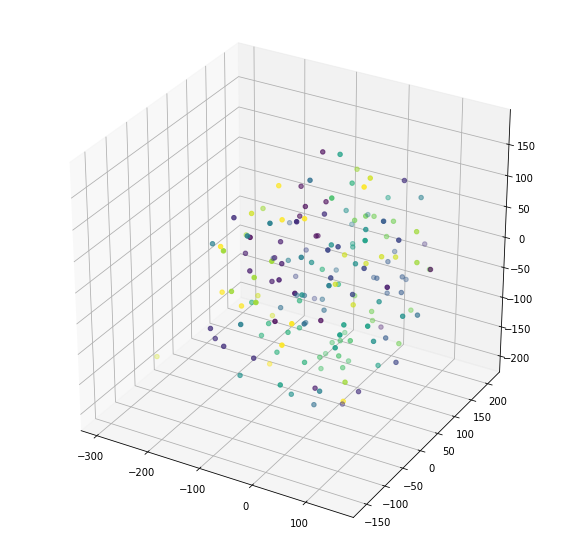

Dataset shape: (400, 32, 32, 3)
IMFDB


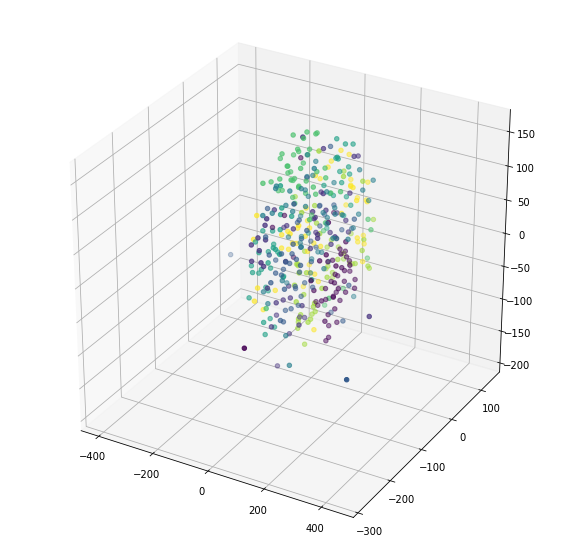

Dataset shape: (672, 32, 32, 3)
IIIT-CFW


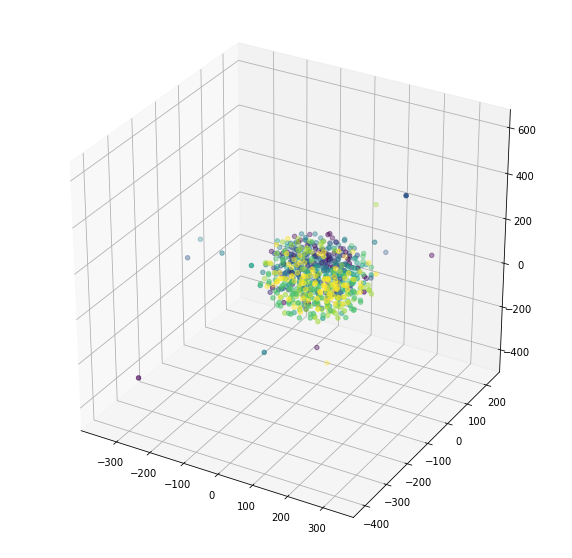

In [28]:
# Compute TSNE for different features and create a scatter plot
# Compute
temp_str=["Yale_face_database","IMFDB","IIIT-CFW"]
temp_str1=deepcopy(temp_str)
for d in range(0,3):
    temp_str[d]="./dataset/"+temp_str[d]
    
for k in range(0,3):
    X,y = load_data(temp_str[k])
    N,H,W = X.shape[0:3]
    C = 1 if opt['is_grayscale'] else X.shape[3]
    X = X.reshape((N,H*W*C))
    X_TSNE = TSNE(n_components=3).fit_transform(X)
    X1_3D=X_TSNE
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X1_3D[:,0],X1_3D[:,1],X1_3D[:,2],c=y)
    print(temp_str1[k])
    plt.show()

# Plot the representation in 2d/3d


4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [29]:
from sklearn.metrics import confusion_matrix as confuse_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
class FaceVerification():
    def __init__(self,X_train,y_train,X_test,y_test):
        #super.__init__()
        self.X_train=X_train
        self.y_train=y_train
        self.X_test=X_test
        self.y_test=y_test
    def verify(self,classif):
        """
            Given an input X classify it into appropriate class.
        """
        pred=classif.predict(self.X_test)
        return pred
        
    def confusion_matrix(self,pred):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        cm = confuse_matrix(self.y_test,pred)
        return cm
    
    def train(self,params):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label

            @return Nothing
        """
        if params=='KNN':
            classy=KNeighborsClassifier(n_neighbors=4)
            clf=classy.fit(self.X_train,self.y_train)
            final=self.validate(clf)
            return final
    def validate(self,clf_param):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        result=[]
        predict=self.verify(clf_param)
        cm=self.confusion_matrix(predict)
        accuracy=cm.trace()/(self.X_test).shape[0]
        result.append(accuracy*100)
        result.append(cm)
        metrics_list=[]
        metrics=precision_recall_fscore_support(self.y_test, predict,average='macro')
        metrics_list.append(metrics[0]*100)
        metrics_list.append(metrics[1]*100)
        metrics_list.append(metrics[2]*100)
        result.extend(metrics_list)
        result=np.array(result[0:5])
        return result

In [31]:
# Create a train and validation split and show your results
temp_str=["Yale_face_database","IMFDB","IIIT-CFW"]
temp1_str=deepcopy(["Yale_face_database","IMFDB","IIIT-CFW"])
classes=[15,8,8]
for d in range(0,3):
    temp_str[d]="./dataset/"+temp_str[d]
for k in range(0,3):
        accu=[]
        confs=[]
        X,y = load_data(temp_str[k])
        N,H,W = X.shape[0:3]
        C = 1 if opt['is_grayscale'] else X.shape[3]
        X = X.reshape((N,H*W*C))
        cm=[]
        train_data,test_data,train_labels,test_labels=split_data(X,y)
        mat_metric=[]
        
        classif=FaceVerification(train_data,train_labels,test_data,test_labels)
        #classif=FaceVerification(X,y,X,y)
        KNN_classif=classif.train('KNN')
        mat_metric.append(KNN_classif)
        mat_metric=np.array(mat_metric)
        print(temp1_str[k])
        print("The classification accuracy is:-")
        print(mat_metric[0][0])

Dataset shape: (165, 32, 32, 3)
Yale_face_database
The classification accuracy is:-
91.11111111111111
Dataset shape: (400, 32, 32, 3)
IMFDB
The classification accuracy is:-
45.83333333333333
Dataset shape: (672, 32, 32, 3)
IIIT-CFW
The classification accuracy is:-
33.33333333333333


In [32]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

# Print the table. (You can use Pandas)
columns=['Method','Reduced','Classification_error','Accuracy','F1-Score']
data=[]
index1=['1','2','3','4','5','6']
temp_str=["Yale_face_database","IMFDB","IIIT-CFW"]
temp_str1=deepcopy(temp_str)
for d in range(0,3):
    temp_str[d]="./dataset/"+temp_str[d]
data=[]

func_arr=[get_pca,get_kernel_pca,get_lda,get_kernel_lda,get_vgg_features,get_resnet_features]
func_str=['get_pca','get_kernel_pca','get_lda','get_kernel_lda','get_vgg_features','get_resnet_features']
#classif_arr=['MLP','Logistic_Regression','SVM','Decision_trees']
conf_mat=[]
for i in range(0,3):
    X,y = load_data(temp_str[i])
    N,H,W = X.shape[0:3]
    C = 1 if opt['is_grayscale'] else X.shape[3]
    X = X.reshape((N,H*W*C))
    for j in range(0,len(func_arr)):
        if j==0:
                feat=func_arr[j](X,100)
        if j==2:
            feat=func_arr[j](X,y,100)
        if j==4 or j==5:
            feat=func_arr[j](temp_str[i])
        if j==1:
            feat=func_arr[j](X,100,kernel='rbf', degree=3)
        if j==3:
            feat=func_arr[j](X,y,100,kernel='rbf',degree=3)
        train_data,test_data,train_labels,test_labels=split_data(feat,y)
        classif=FaceVerification(train_data,train_labels,test_data,test_labels)
        temp_classif=classif.train('KNN')
        conf_mat.append(temp_classif[1])
        s3 = "{}+{}".format(func_str[j],'KNN')
        data.append([s3,feat.shape[1],100-temp_classif[0],temp_classif[0],temp_classif[4]])
data=np.array(data)
dd=0
print(data.shape)
while dd<data.shape[0]:
    df=pd.DataFrame(data[dd:dd+6],columns=columns, index=index1)
    if dd>=0 and dd<6:
        print("Yale_face_database")
    elif dd>=6 and dd<12:
        print("IMFDB")
    else:
        print("IIIT-CFW")
    display(df)
    dd=dd+6

Dataset shape: (165, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
(18, 5)
Yale_face_database


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_pca+KNN,100,8.888888888888886,91.11111111111111,91.0952380952381
2,get_kernel_pca+KNN,100,8.888888888888886,91.11111111111111,91.0952380952381
3,get_lda+KNN,14,0.0,100.0,100.0
4,get_kernel_lda+KNN,14,0.0,100.0,100.0
5,get_vgg_features+KNN,4096,46.666666666666664,53.333333333333336,51.915343915343904
6,get_resnet_features+KNN,2048,0.0,100.0,100.0


IMFDB


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_pca+KNN,100,54.16666666666667,45.83333333333333,44.31547619047619
2,get_kernel_pca+KNN,100,54.16666666666667,45.83333333333333,44.25595238095239
3,get_lda+KNN,7,4.166666666666657,95.83333333333334,95.71428571428572
4,get_kernel_lda+KNN,7,4.166666666666657,95.83333333333334,95.71428571428572
5,get_vgg_features+KNN,4096,4.166666666666657,95.83333333333334,95.71428571428572
6,get_resnet_features+KNN,2048,0.0,100.0,100.0


IIIT-CFW


,Method,Reduced,Classification_error,Accuracy,F1-Score
1,get_pca+KNN,100,58.33333333333333,41.66666666666667,42.82828282828282
2,get_kernel_pca+KNN,100,62.5,37.5,39.16666666666667
3,get_lda+KNN,7,4.166666666666657,95.83333333333334,95.71428571428571
4,get_kernel_lda+KNN,7,4.166666666666657,95.83333333333334,95.71428571428571
5,get_vgg_features+KNN,4096,29.166666666666657,70.83333333333334,69.94047619047619
6,get_resnet_features+KNN,2048,8.333333333333343,91.66666666666666,91.42857142857143


### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [33]:
# Load data
#Politicians vs Filmstars in a public data set.
from sklearn.model_selection import train_test_split
cfw_dict_modified= {'Amitabhbachan': 0,
    'AamirKhan': 0,
    'DwayneJohnson': 0,
    'AishwaryaRai': 0,
    'BarackObama': 1,
    'NarendraModi': 1,
    'ManmohanSingh': 1,
    'VladimirPutin': 1}

# Iterating through the Image_data set and changing the y labels.

def load_data_modified(dir_path):
    image_list = []
    y_list = []
    if "CFW" in dir_path:
        label_dict =cfw_dict_modified
    else:
        raise KeyError("Dataset not found.")
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            tag = label_dict[y] 
            if(tag==0):
                image_list.append(im)
                y_list.append(0)
                #print(y)
            elif(tag==1):
                image_list.append(im)
                y_list.append(1)
                #print(y)
            else:
                print('INVALID')
                
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",y_list.shape)
    return image_list,y_list
X,y=load_data_modified("./dataset/IIIT-CFW")
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
print(X.shape)
print(y.shape)

Dataset shape: (672,)
(672, 3072)
(672,)


In [35]:
# Define your features
#Dimensionality reduction by Resnet_features
X=get_resnet_features("./dataset/IIIT-CFW")
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,shuffle='True')

In [36]:
# Create your classifier
# Validate your classifier
classy=MLPClassifier(hidden_layer_sizes=(1024,512,64),max_iter=200,batch_size=20,activation='relu')
clf=classy.fit(X_train,y_train)
final=clf.predict(X_test)
conf=confuse_matrix(y_test,final)
#print((conf.trace()/y_test.shape[0])*100)

The accuracy is:-
100.0
The k-fold validation accuracy is:-
0.9569817578772802
TSNE Plot for IIIT-CFW


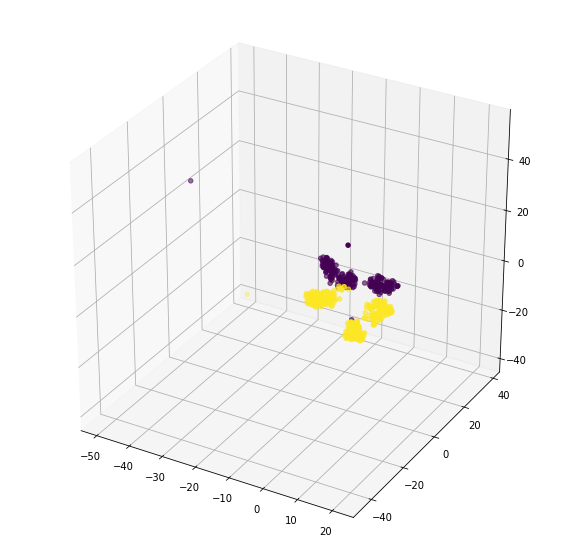

In [37]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc. 
print("The accuracy is:-")
print((conf.trace()/y_test.shape[0])*100)
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
#knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print("The k-fold validation accuracy is:-")
print(np.mean(scores))
X_TSNE = TSNE(n_components=3).fit_transform(X)
X1_3D=X_TSNE
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1_3D[:,0],X1_3D[:,1],X1_3D[:,2],c=y)
print("TSNE Plot for IIIT-CFW")
plt.show()

In [40]:
# Show quantitative results such as examples of correct prediction and wrong prediction